In [330]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats, io
from fooof import FOOOFGroup

import warnings
warnings.filterwarnings("ignore")

sys.path.append('../')
import utils

font = {'family' : 'Tahoma',
        'weight' : 'regular',
        'size'   : 12}

import matplotlib
matplotlib.rc('font', **font)
C_ORD = plt.rcParams['axes.prop_cycle'].by_key()['color']

save_plot = True
fig_path = '../figures/neurotycho/%s.pdf'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get spiking population time constants & ECoG electrode locations

In [184]:
# get mean population time constants, values grabbed from Murray et al., 2014
cell_ts = {'MT':[77.,64.], 'LIP':[138., 91.], 'LPFC':[184.,180.,195.,162.], 'OFC':[176.,188.], 'ACC':[313.,340.,257.], 'S1':[65.], 'S2':[149.]}
cell_ts_avg = {k: np.array([np.mean(np.array(v)/1e3), stats.sem(np.array(v)/1e3)*2]) for k,v in cell_ts.items()}

# electrode indices for each of the corresponding areas in each monkey
loc_inds_chibi = {'MT':[3,4,109], 'LIP':[10,11], 'LPFC':[14,15,25,26], 'OFC':[23,34,45], 'ACC':[52,57,58,59], 'S1':[9,19], 'S2':[95,108]}
loc_inds_george = {'MT':[4,13,22], 'LIP':[10,11,20,21], 'LPFC':[15,24,25,26], 'OFC':[45,66], 'ACC':[52,57,58,59], 'S1':[18,19,30], 'S2':[1,2,9,108]}
loc_inds = {'Chibi': loc_inds_chibi, 'George': loc_inds_george}

area_ord = [3,1,2,0,4,6,5] # color order to match Murray figure

# Collect fooof results and electrode info into Dataframe

In [3]:
# get cortex files
chibi_ctx_file = '/Users/rdgao/Documents/data/NeuroTycho/Propofol/GridLocations/20110621KTMD_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_2Dimg/ChibiMap.mat'
george_ctx_file = '/Users/rdgao/Documents/data/NeuroTycho/Propofol/GridLocations/20110112KTMD_Anesthesia+and+Sleep_George_Toru+Yanagawa_mat_2Dimg/GeorgeMap.mat'
ctx_loc = []
for ind, ctx_file in enumerate([chibi_ctx_file, george_ctx_file]):
    ctx_mat = io.loadmat(ctx_file, squeeze_me=True)
    ctx_loc.append(np.array([ctx_mat['X'], ctx_mat['Y']]).T)

In [234]:
win_len, p_cur = '1sec', 'psd_med'
fg_param_to_load = 'knee'
df_combined = pd.DataFrame()
col_names = ['patient','cond','pharm', 'session_id', 'chan', 'exp', 'knee', 'tau','log_tau','err', 'r2']

# load fooof results
result_basepath = '/Users/rdgao/Documents/code/research/field-echos/results/neurotycho/rest_anes/'
session_resultpath = np.sort([f+'/' for f in os.listdir(result_basepath) if os.path.isdir(result_basepath+f)])
session_dict = {id:ind for ind, id in enumerate(np.unique([s.split('_')[3] for s in session_resultpath]))}
for s in session_resultpath:
    fooof_folder = result_basepath + s +'/psd/'+win_len+'/fooof/'+p_cur+'/'    
    ff_list = [ff for ff in os.listdir(fooof_folder) if '.json' in ff]
    ff_file = ff_list[np.where([fg_param_to_load in f for f in ff_list])[0][0]] # load specific fooof file
    
    # return fooof fits and convert knee to tau
    fg_aps, fg_pks, fg_err, fg_r2s = utils.return_fg_fits(ff_file, fooof_folder)
    if fg_aps.shape[1]==3:
        knee_freq, knee_tau = utils.convert_knee_val(fg_aps[:,1],fg_aps[:,2])
        knee = fg_aps[:,1]
    else:
        knee_tau = np.zeros_like(fg_aps[:,0])
        knee = np.zeros_like(fg_aps[:,0])
    
    df_data = np.vstack((fg_aps[:,-1], knee, knee_tau, np.log10(knee_tau), fg_err, fg_r2s)).T
    s_spl = s.split('_')
    patient, cond, pharm, session_id = s_spl[7], s_spl[1], s_spl[2], session_dict[s_spl[3]]
    chan = np.arange(len(fg_err))+1
    df_cur = pd.DataFrame(np.hstack((np.repeat(np.array([patient,cond,pharm, session_id])[:,None].T, len(fg_err), axis=0), chan[:,None], df_data))
                 ,columns=col_names)
    df_cur.insert(5,'y', ctx_loc[0 if patient is 'Chibi' else 1][:,0])
    df_cur.insert(6,'z', ctx_loc[0 if patient is 'Chibi' else 1][:,1])

    df_combined = df_combined.append(df_cur, ignore_index=True)

df_combined.columns
df_combined = df_combined.astype({c:str if c in ['patient', 'cond', 'pharm'] else np.float for c in col_names})

# Plotting Results

# Test correlation with monkey spiking dataset

In [337]:
# define querying condition
cond_query = 'EyesClosed'
df_cond = df_combined[df_combined['cond']==cond_query] 

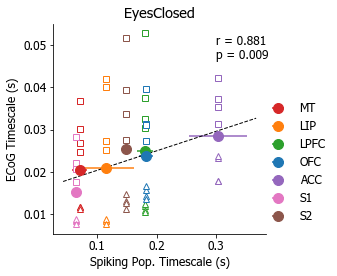

In [338]:
plt.figure(figsize=(4,4))
ecog_ts_avg = {}
# plot per session average across electrodes
for i, k in enumerate(cell_ts.keys()):
    sesh_mkrs = [] # hack to save the session marker for next plot
    ecog_ts_avg[k] = []
    for s in df_cond['session_id'].unique():
        df_sesh = df_cond[df_cond['session_id']==s]
        patient = df_sesh['patient'].iloc[0]

        # loc_inds has the ecog electrode indices that fall into each area
        region_inds = loc_inds[patient][k] 
        marker = 's' if patient == 'George' else '^'
        sesh_mkrs.append(marker)
        ecog_ts_sess_avg = df_sesh.loc[df_sesh['chan'].isin(region_inds)].mean()[feature]
        ecog_ts_avg[k].append(ecog_ts_sess_avg)
        plt.plot(cell_ts_avg[k][0], ecog_ts_sess_avg, marker,color=C_ORD[area_ord[i]], ms=6, mfc='w')

# plot grand average
for i,k in enumerate(cell_ts.keys()):
    plt.errorbar(cell_ts_avg[k][0], np.mean(ecog_ts_avg[k]), xerr=cell_ts_avg[k][1], fmt='o', color=C_ORD[area_ord[i]], ms=10, label=k)

# fit & plot line
ts_mat = np.array([(cell_ts_avg[k][0], np.mean(ecog_ts_avg[k])) for k in cell_ts.keys()])
m,b,r,pv,stderr = stats.linregress(ts_mat)
XL = np.array(plt.xlim())
plt.plot(XL,XL*m+b, 'k--', lw=1)
plt.text(0.3,0.85*plt.ylim()[1], 'r = %.3f\np = %.3f'%(r,pv))

plt.legend(loc='lower left', bbox_to_anchor= (0.95, 0), ncol=1, frameon=False)
plt.xlabel('Spiking Pop. Timescale (s)');plt.ylabel('ECoG Timescale (s)'); plt.title(cond_query)
utils.remove_spines(plt.gca()); plt.tight_layout()
if save_plot: plt.savefig(fig_path%('NT_spikeECoG_'+cond_query), bbox_inches='tight')

# Fitting linear model to each session

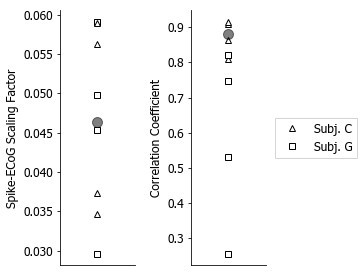

In [339]:
ecog_ts_mat = np.array([ecog_ts_avg[k] for k in cell_ts.keys()])
cell_ts_mat = np.array([cell_ts_avg[k][0] for k in cell_ts.keys()])
session_stats = np.array([stats.linregress(cell_ts_mat, ecog_ts_mat[:,i]) for i in range(ecog_ts_mat.shape[1])])

plt.figure(figsize=(4,4))
plt.subplot(1,2,1)
for s_i, s in enumerate(sesh_mkrs): plt.plot(0, session_stats[s_i,0], mec='k', mfc='w', ms=6, marker=s)
plt.plot(0, m,'ko', ms=10, alpha=0.5)
utils.remove_spines(plt.gca(), ['right', 'top'])
plt.xticks([]); plt.ylabel('Spike-ECoG Scaling Factor')

plt.subplot(1,2,2)
for s_i, s in enumerate(sesh_mkrs): plt.plot(0, session_stats[s_i,2],mec='k', mfc='w', ms=6, marker=s)
plt.plot(0, r,'ko', ms=10, alpha=0.5)
utils.remove_spines(plt.gca(), ['right', 'top'])
plt.xticks([]); plt.ylabel('Correlation Coefficient')
lg = plt.legend(['Subj. C','Subj. G'], bbox_to_anchor= (2.3, 0.6), fancybox=False)
for l in lg.legendHandles: l.set_linewidth(0)
plt.tight_layout(); 
if save_plot: plt.savefig(fig_path%('NT_EcoGSpikeScaling_'+cond_query), bbox_inches='tight')

### Spiking timescale highly correlates with LFP timescale
Across sessions, as well as in the grand average, spiking population timescale values (taken from Murray et al. 2014 NatNeuro) correlates with LFP timescale. However, there is a scaling factor of about 10 (i.e., T_spiking = 10\*T_ECoG ), suggesting two separate but dependent processes. Perhaps LFP timescale measures something more closely resembling membrane potential time constant.

# Plot tau along anterior-posterior axis

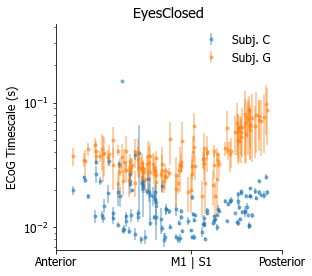

In [340]:
feature = 'tau'
plt.figure(figsize=(4.5,4))
# group by subject at the highest level, then channel, then perform average (over sessions)
grand_agg = df_cond.groupby(['patient', 'chan'])[df_combined.columns[3:]].agg([np.nanmean, stats.sem])
for g_i, g in grand_agg.groupby('patient'):
    plt.errorbar(g['y']['nanmean'], g[feature]['nanmean'], yerr=g[feature]['sem']*2., fmt='.', alpha=0.5)
    # normalize per subject
    #plt.errorbar(g['y']['nanmean'], g[feature]['nanmean']/g[feature]['nanmean'].min(), yerr=g[feature]['sem']*2., fmt='.')
    
plt.yscale('log'); plt.legend(['Subj. C', 'Subj. G'], frameon=False); 
utils.remove_spines(plt.gca())
plt.xticks([0,600,1000],['Anterior','M1 | S1','Posterior'])
plt.ylabel('ECoG Timescale (s)'); plt.title(cond_query)
plt.tight_layout()
if save_plot: plt.savefig(fig_path%('NT_TauAcrossAP_'+cond_query))

### Timescale increases from central sulcus towards frontal and occiptal poles
Since there is full cortex coverage, we can measure timescale across the entire brain. Sensorimotor regions have the shortest timescale, while frontal regions by far have the longest timescale. Visual cortex, surprisingly, does not have the shortest timescale. 

# Comparing across conditions

True
True
True
True
True
True
True
True


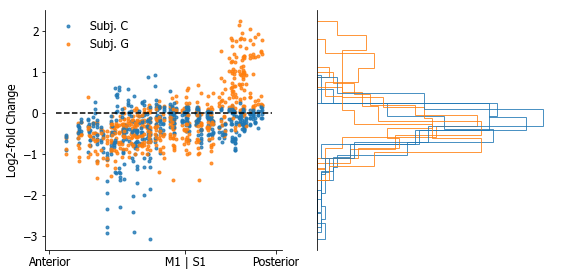

In [341]:
feature = 'tau'
conds_comp = ['EyesOpen','EyesClosed']
plt.figure(figsize=(8,4))
for s in df_combined['session_id'].unique():
    df_comp = [df_combined[np.logical_and(df_combined['cond']==c, df_combined['session_id']==s)] for c in conds_comp]

    # check that the subsampled rows are properly aligned in space and session
    print(np.logical_and(df_comp[1]['y']==df_comp[1]['y'],df_comp[1]['session_id']==df_comp[1]['session_id']).all())
    cond_ratio = np.log2(df_comp[1][feature].values/df_comp[0][feature].values)
    C = C_ORD[0 if df_comp[0].iloc[0]['patient']=='Chibi' else 1]

    # plot along A-P axis
    plt.subplot(1,2,1)
    plt.plot(df_comp[1]['y'], cond_ratio, '.', color=C, alpha=0.8)
    
    # plot histogram
    plt.subplot(1,2,2)
    plt.hist(cond_ratio[~np.isnan(cond_ratio)], 10, histtype='step', color=C, orientation='horizontal', alpha=0.8)

plt.subplot(1,2,1)
plt.plot(plt.xlim(),[0,0],'k--')
plt.legend(['Subj. C', 'Subj. G'], frameon=False); 
plt.xticks([0,600,1000],['Anterior','M1 | S1','Posterior'])
plt.ylabel('Log2-fold Change');
utils.remove_spines(plt.gca())

plt.subplot(1,2,2)
plt.xticks([]); plt.yticks([])
utils.remove_spines(plt.gca(), ['right', 'top', 'bottom'])
plt.tight_layout()
if save_plot: plt.savefig(fig_path%('NT_EO2EC'), bbox_inches='tight')

# Plot tau-exp correlation

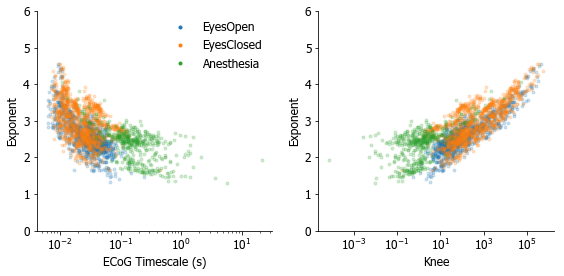

In [342]:
plt.figure(figsize=(8,4))
for cond in df_combined['cond'].unique()[[0,1,3]]:
    df_plot = df_combined[df_combined['cond']==cond]
    plt.subplot(1,2,1)
    plt.semilogx(df_plot['tau'],df_plot['exp'],'.', alpha=0.2, label=cond)
    plt.xlabel('ECoG Timescale (s)'); plt.ylabel('Exponent'); plt.ylim([0, 6]); utils.remove_spines(plt.gca())
    # knee-exp
    plt.subplot(1,2,2)
    plt.semilogx(df_plot['knee'],df_plot['exp'],'.', alpha=0.2, label=cond)
    plt.xlabel('Knee'); plt.ylabel('Exponent'); plt.ylim([0, 6]); utils.remove_spines(plt.gca())   

plt.subplot(1,2,1); 
lg=plt.legend(fancybox=False, frameon=False)
for l in lg.legendHandles: l._legmarker.set_alpha(1)
plt.tight_layout()
if save_plot: plt.savefig(fig_path%'NT_tau_exp')

### Timescale vs. scale-free
In all the conditions, PSD exponent and timescale (knee) are very correlated, signifying a relationship between the two processes: one with a characteristic timescale and one scalefree. Importantly, this is not an artifact of the timescale computation, as that would induce the opposite correlation (see human ECoG notebook for simulation).

# Macaque ECoG vs. Spiking Timescale
Single unit spiking timescale correlates with ECoG characteristic timescale across cortical areas. More generally, timescale increases moving from posterior to anterior regions of the brain, "up the cortical hierarchy".

However, there is a conversion factor of ~0.1 from ECoG to spiking, i.e. ECoG timescale is 1/10 of single unit spike timing timescale. Why is that?
1. timescale correlation is due to chance, or some other factor in the ECoG, e.g., dendritic/membrane integration constant
2. spiking is local output, whereas ECoG is (mostly) input, so the time constant measured in ECoG is spiking from the afferent region
3. single unit time constant is different from population time constant, which has been proposed as the benefit of asynchronous population spiking (faster reaction, e.g., van Vreeswijk, Destexhe)
4. local recurrent dendritic processes "filter" spiking, most likely in a low-pass fashion. Thus, whatever process with the highest time constant (lower frequency knee) will dominate in the retrieved timescale
5. they have nothing to do with each other and this is just random

**Should try gamma or broadband power autocorrelation over time to match with the spiking timescale.**

# Slope vs. Knee
Current points of investigation:
- Median fit knee is most consistent in correlating with timescale, and in general, produces more robust fits for the PSD (less nans, i.e., negative knees).

- When fit with knee, slope also (negative) correlates with single unit time constant. However, when just fit using a line in the full range, slope does NOT correlate with time constant. This is surprising, as I would have expected the knee-removed slope to be independent of the timescale, and the non-knee-removed slope fits are essentially corrupted by the knee. This indicates that the characteristic timescale (in exponential decay) is correlated with the power-law decay (???), suggesting multiple processes with multiple temporal time characteristics.

- For example, exponential decay constant (knee) may arise from synaptic time constant, while the power law relation may be from population spiking autocorrelation.

- need to check this with just linear range fits.